In [1]:
# autoreload -- Use for development only
%load_ext autoreload
%autoreload 2

# Carefully interpreting your model

In [2]:
# Double check you have a GPU available
import torch
torch.cuda.is_available()

True

In [3]:
# Define any useful paths
import os
import glob
cwd = "/cellar/users/aklie/projects/ML4GLand/use_cases/jores21"

In [4]:
# Load in the preprocessed training data
import seqdata as sd
leaf_test = sd.read_h5sd("/cellar/users/aklie/data/eugene/jores21/leaf_processed_test.h5sd")
leaf_test

SeqData object with = 7154 seqs
seqs = (7154,)
names = (7154,)
rev_seqs = None
ohe_seqs = (7154, 4, 170)
ohe_rev_seqs = None
seqs_annot: 'GC', 'barcodes', 'batch', 'chromosome', 'end', 'enrichment', 'gene', 'mutations', 'set', 'sp', 'start', 'strand', 'type'
pos_annot: None
seqsm: None
uns: None

In [5]:
# One-hot encode the sequences
from eugene import preprocess as pp
pp.ohe_seqs_sdata(leaf_test)

# Load trained model

In [8]:
model_file = glob.glob(os.path.join(cwd, "models", "grace", "leaf", "checkpoints", "*.ckpt"))[0]
model_file

'/cellar/users/aklie/projects/ML4GLand/use_cases/jores21/models/grace/leaf/checkpoints/epoch=10-step=5027.ckpt'

In [9]:
# Load the model
from eugene import models
import importlib
def load_model(model_path):
    model_state = torch.load(model_path)
    arch = model_state["hyper_parameters"]["arch"]
    model_type = getattr(importlib.import_module("eugene.models"), arch)
    model = model_type(**model_state["hyper_parameters"])
    model.load_state_dict(model_state["state_dict"])
    return model
model = load_model(model_file)

In [14]:
# Grab precitions from the model
leaf_test["enrichment_predictions"] = model.predict(leaf_test.ohe_seqs, batch_size=128).cpu().numpy()

In [15]:
# Plot the predictions and metrics
from eugene import plot as pl
ax = pl.performance_scatter(
    leaf_test,
    target_keys="enrichment", 
    prediction_keys="enrichment_predictions",
    alpha=0.5,
    c="GC",
    figsize=(10, 10),
)

# Feature attribution

In [12]:
import seqexplainer as se

In [36]:
attrs = se.attribute_on_batch(
    model,
    inputs=torch.Tensor(leaf_test.ohe_seqs),
    method="DeepLiftShap",
    reference_type="shuffle",
    batch_size=16,
    device="cuda"
)

Computing feature attributions on batches of size 16:   0%|          | 0/448 [00:00<?, ?it/s]

# Filter interpretation

In [110]:
layer_name = "conv1d_tower.layers.1"

In [524]:
from seqexplainer._utils import get_layer_outputs
from seqexplainer._filters import get_activators_n_seqlets, get_activators_max_seqlets
from seqexplainer._filters import get_pfms, pfms_to_df_dict
from seqexplainer._filters import pfms_to_ppms, ppms_to_pwms, ppms_to_igms, per_position_ic
from seqexplainer._filters import plot_filter_logo, plot_filter_logos

In [525]:
sequences = leaf_test.ohe_seqs
layer_outs = get_layer_outputs(model, sequences, layer_name, device="cuda")
activators = get_activators_n_seqlets(
    layer_outs,
    sequences,
    kernel_size=13,
    num_seqlets=100
)
pfms = get_pfms(activators)
pfm_dfs = pfms_to_df_dict(pfms)
ppms = pfms_to_ppms(pfms, pseudocount=1)
pwms = ppms_to_pwms(ppms)
infos = ppms_to_igms(ppms)
ppics = per_position_ic(ppms)
tot_ics = ppics.sum(axis=1)

Computing layer outputs for layer conv1d_tower.layers.1 on batches of size 128:   0%|          | 0/56 [00:00<?…

Getting filter activators for 256 filters:   0%|          | 0/256 [00:00<?, ?it/s]

In [526]:
# Sort by total information content
sort_idx = np.argsort(tot_ics)[::-1]
sort_idx[:5]

array([50, 46, 72, 71,  0])

In [ ]:
plot_filter_logo(mtx=pfm[sort_idx[-1]], mtx_type="counts")

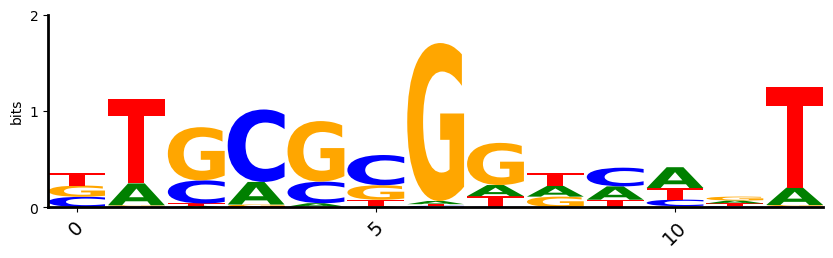

In [532]:
plot_filter_logo(mtx=ppms[sort_idx[-1]], mtx_type="probability")

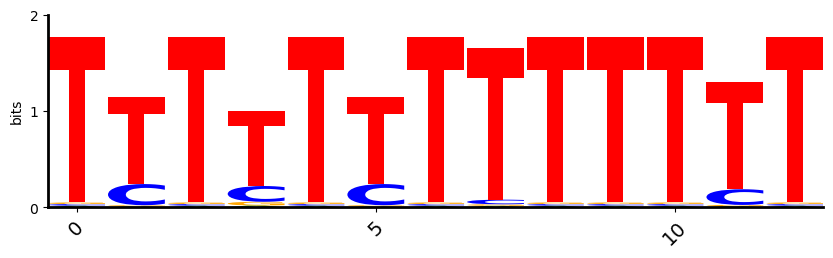

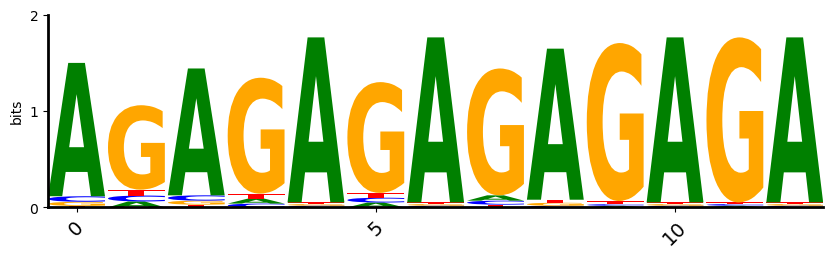

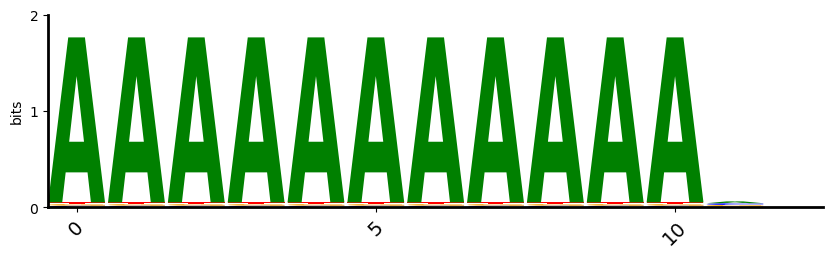

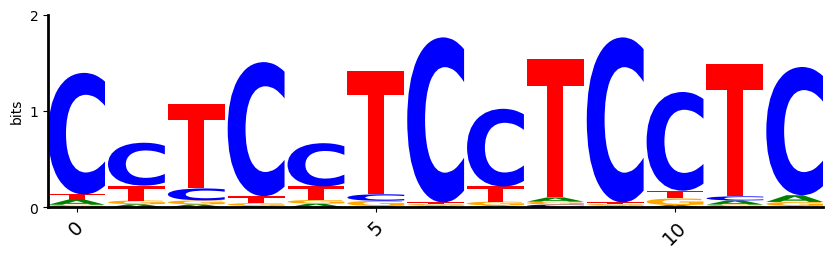

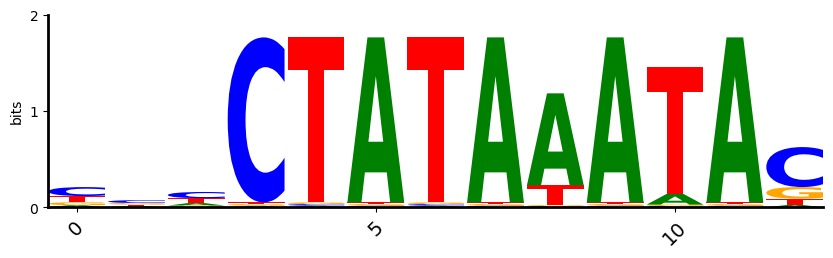

In [533]:
plot_filter_logos(mtxs=ppms[sort_idx[:5]], mtx_type="probability")

---

# DONE!

# Scratch

In [ ]:
# Test against Peter Koo's code
import numpy as np
TINY = np.finfo(np.float32).tiny
def compute_per_position_ic(ppm, background, pseudocount):
    alphabet_len = len(background)
    ic = ((np.log((ppm+pseudocount)/(1 + pseudocount*alphabet_len))/np.log(2))
          *ppm - (np.log(background)*background/np.log(2))[None,:])
    return np.sum(ic,axis=1)
compute_per_position_ic(ppms[0], np.array([0.25, 0.25, 0.25, 0.25]), TINY)

In [ ]:
# Test against logomaker
from logomaker.src.matrix import _probability_mat_to_information_mat
_probability_mat_to_information_mat(pd.DataFrame(ppms[0]))